In [1]:
from dotenv import load_dotenv
import os

from langchain_neo4j import Neo4jGraph

load_dotenv('C:/Users/tjker/Desktop/Research/Projects/lit_review/lit_review/.env', override=True)
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")

kg = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)

cypher = """
MATCH (n)
RETURN count(n) AS numberOfNodes
"""

result = kg.query(cypher)
result

[{'numberOfNodes': 4128}]

In [2]:
config = {
    "llm": {
        "provider": "huggingface",    # options: "ollama", "openai", "huggingface", etc.
        'model_id': 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B',
        "max_seq_len": 16384,
        "num_predict": 16384,
        "temperature": 0.5,
        "api_key": "YOUR_API_KEY_IF_NEEDED"  # only used for some providers
    },
    'database': {
        'uri': os.getenv("NEO4J_URI"),
        'username': os.getenv("NEO4J_USERNAME"),
        'password': os.getenv("NEO4J_PASSWORD"),
        'database': os.getenv("NEO4J_DATABASE")
    },
    "embedding": {
        "provider": "huggingface",
        "model_id": 'sentence-transformers/multi-qa-mpnet-base-dot-v1'
    },
    'rag': {
        'index_name': 'paper_chunks',
        'embedding_node_property': 'textEmbedding',
        'text_node_property': 'text'
    }
}

In [3]:
import sys
sys.path.append("/app/src")  # Add to Python's search path

# Now you can import modules
from rag import rag_utils as rag  # Replace with actual module name

llm_adapter = rag.get_llm(config)
emb_adapter = rag.get_embeddings(config)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from langchain_neo4j import Neo4jVector

vis_query = """
MATCH (p:Paper)
WHERE p.abstract IS NOT NULL AND p.abstract <> ''
WITH DISTINCT p, vector.similarity.cosine(p.abstractEmbedding, $embedding) AS score
ORDER BY score DESC LIMIT $k
RETURN p.abstract AS text, score, properties(p) AS metadata
"""

abstract_vector = Neo4jVector.from_existing_index(
    emb_adapter,
    graph=kg, 
    index_name='abstract_embeddings',
    embedding_node_property='abstractEmbedding',
    text_node_property='abstract',
    retrieval_query=vis_query,
)

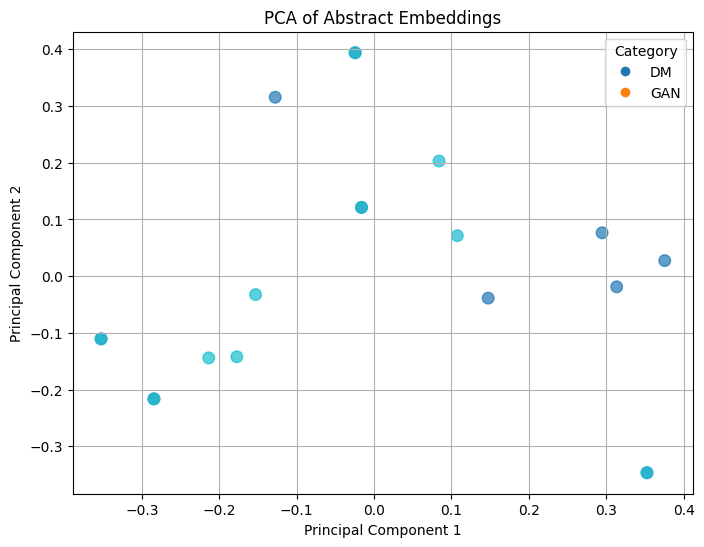

In [5]:
from src.kg.visualize_embeddings import generate_plot_from_query

query = ["Papers that discuss methods applied to diffusion models.", "Papers that discuss methods applied to GANs."]
color_var = "labels"

generate_plot_from_query(
    query,
    abstract_vector,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=["DM", "GAN"]
)

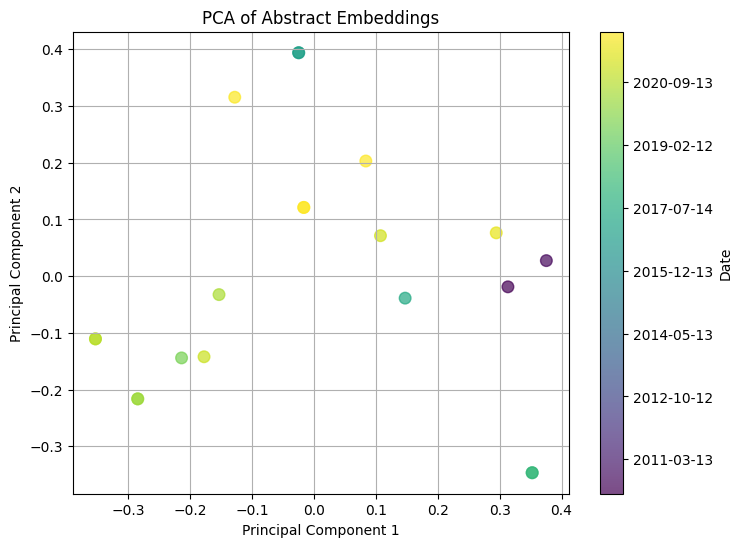

In [6]:
query = ["Papers that discuss methods applied to diffusion models.", "Papers that discuss methods applied to GANs."]
color_var = "dates"

generate_plot_from_query(
    query,
    abstract_vector,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=["DM", "GAN"]
)

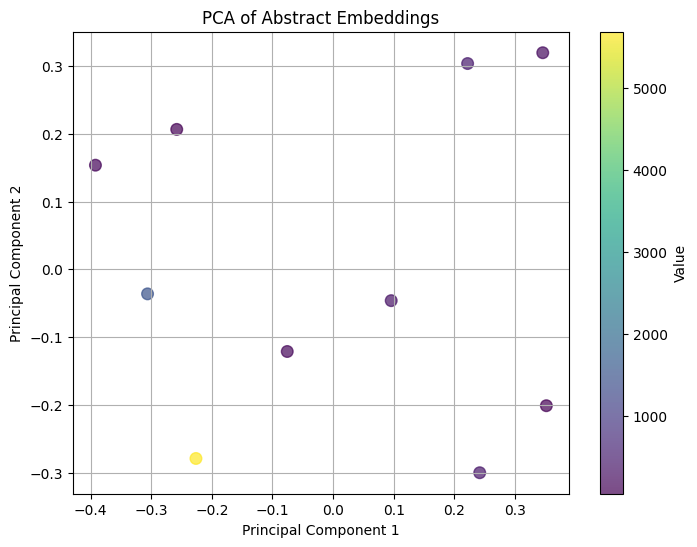

In [7]:
query = ["Papers that discuss methods applied to diffusion models."]
color_var = "citationCount"

generate_plot_from_query(
    query,
    abstract_vector,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=None
)

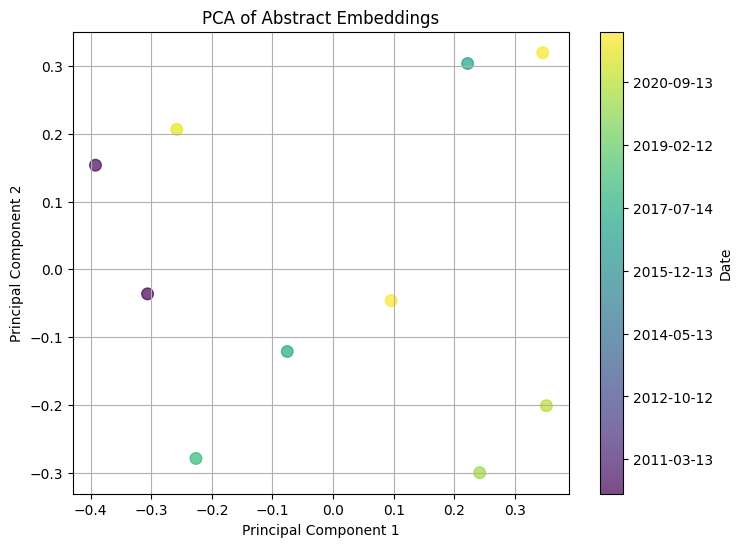

In [8]:
query = ["Papers that discuss methods applied to diffusion models."]
color_var = "dates"

generate_plot_from_query(
    query,
    abstract_vector,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=None
)

In [ ]:
# import io
# import base64

# # Generate the figure
# fig = plot_pca_embeddings(embeddings, date_floats, is_date=True, norm=norm, cmap='viridis')

# # Save figure to a buffer
# buf = io.BytesIO()
# fig.savefig(buf, format='png')
# buf.seek(0)
# encoded_img = base64.b64encode(buf.read()).decode('utf-8')